# The Language of Venom: Detecting Toxic Tweets in the Wild

---
Link https://www.kaggle.com/datasets/umitka/twitter-toxic-tweets


Ah, Twitter. The place where people argue about politics, celebrities, and whether a hot dog is a sandwich—often in the same thread, often using words that would make a sailor blush.

Today we're building a toxicity detector. Think of it as a smoke alarm for bad vibes. Except instead of beeping at your burnt toast, it beeps at people who peaked in middle school and never recovered.

We have 32,000 tweets. Some are wholesome. Some are... not. Our mission: teach a computer to tell the difference, because apparently humans can't be trusted to behave on the internet. Shocking, I know.

**What's at stake?** If we succeed, platforms get cleaner. If we fail, the model flags "I love my mom" as hate speech and lets actual garbage slide. No pressure.

Grab a snack. This is going to be fun—unlike most of the tweets we're about to analyze.

## Imports

In [8]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import pandas as pd
import kagglehub
import os
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import re
import string
from collections import Counter

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             roc_auc_score, roc_curve, precision_recall_curve,
                             f1_score, precision_score, recall_score, average_precision_score)

# Statistical tests
from scipy import stats
from scipy.stats import mannwhitneyu, shapiro

# Define stopwords inline (no external downloads needed)
STOP_WORDS = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your',
    'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her',
    'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs',
    'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those',
    'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
    'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
    'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with',
    'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',
    'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over',
    'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where',
    'why', 'how', 'all', 'each', 'few', 'more', 'most', 'other', 'some', 'such',
    'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's',
    't', 'can', 'will', 'just', 'don', 'should', 'now', 'd', 'll', 'm', 'o', 're',
    've', 'y', 'ain', 'im', 'ive', 'youre', 'youve', 'hes', 'shes', 'wont', 'dont',
    'cant', 'user', 'rt', 'via', 'amp', 'would', 'could', 'get', 'got', 'like',
    'one', 'also', 'us', 'go', 'going', 'see', 'know', 'way', 'much', 'even', 'back'
])

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print('All libraries loaded successfully.')

All libraries loaded successfully.


## 2. Data Loading and First Impressions

Let's meet our data. Every dataset has a personality, and our first task is to understand its shape, its quirks, and its secrets.

In [6]:
# Download latest version
path = kagglehub.dataset_download("umitka/twitter-toxic-tweets")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'twitter-toxic-tweets' dataset.
Path to dataset files: /kaggle/input/twitter-toxic-tweets


In [4]:
print(os.listdir(path))

['twitter_toxic_tweets.csv']


In [7]:
df = pd.read_csv(os.path.join(path,'twitter_toxic_tweets.csv'))

In [9]:
# Basic shape information
print(f'Dataset Shape: {df.shape[0]:,} rows x {df.shape[1]} columns')
print(f'Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB')
print('\nColumn Data Types:')
print(df.dtypes)

Dataset Shape: 31,962 rows x 3 columns
Memory Usage: 4.73 MB

Column Data Types:
id        int64
label     int64
tweet    object
dtype: object


In [10]:
# First look at the data
print('First 10 rows of our dataset:')
df.head(10)

First 10 rows of our dataset:


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [11]:
# Statistical summary for numerical columns
print('Statistical Summary:')
df.describe()

Statistical Summary:


,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


**First Impressions:**

We have roughly 32,000 tweets, each tagged with a binary label (0 for non-toxic, 1 for toxic). The structure is deliberately simple - just an ID, a label, and the raw tweet text. This simplicity is deceptive; the real complexity hides within those 280 characters of human expression.

Notice already that tweets contain @user mentions (anonymized handles), hashtags, emojis (rendered as unicode artifacts), and the chaotic grammar that defines social media. Our preprocessing will need to handle all of this.

---

## 3. Exploratory Data Analysis

Before we build anything, we must understand. Let's peel back the layers of this dataset.

In [12]:
# Calculate missing values
missing_stats = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})

print('Missing Values Analysis:')
print(missing_stats)

# Check for empty strings in tweets (not technically null but effectively missing)
empty_tweets = (df['tweet'].str.strip() == '').sum()
print(f'\nEmpty tweets (whitespace only): {empty_tweets}')

Missing Values Analysis:
       Missing Count  Missing Percentage
id                 0                 0.0
label              0                 0.0
tweet              0                 0.0

Empty tweets (whitespace only): 0


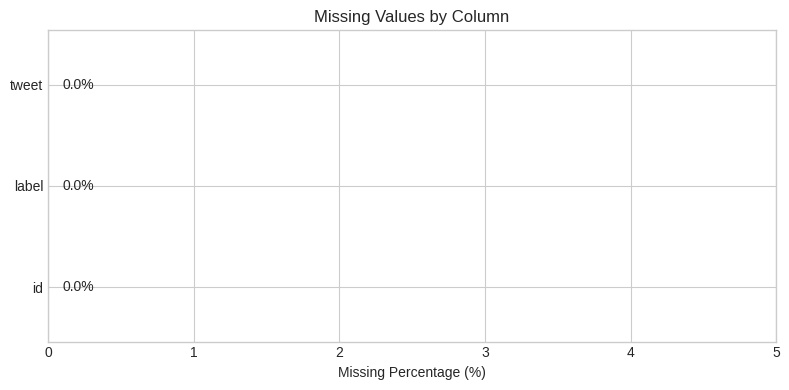

In [13]:
# Visualize missingness pattern
fig, ax = plt.subplots(figsize=(8, 4))
missing_pct = df.isnull().sum() / len(df) * 100
bars = ax.barh(missing_pct.index, missing_pct.values, color='steelblue')
ax.set_xlabel('Missing Percentage (%)')
ax.set_title('Missing Values by Column')
ax.set_xlim(0, max(5, missing_pct.max() + 1))

for bar, val in zip(bars, missing_pct.values):
    ax.text(val + 0.1, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', va='center')

plt.tight_layout()
plt.show()

**Key Insight:** Our data is remarkably complete. No missing values in any column - a luxury not often afforded in real-world datasets. This means we can proceed directly to analysis without imputation strategies.

### 3.2 Target Variable Deep Dive

The label distribution will dictate our entire modeling strategy. An imbalanced target requires special handling.

In [14]:
# Target distribution
label_counts = df['label'].value_counts()
label_pct = df['label'].value_counts(normalize=True) * 100

print('Target Variable Distribution:')
print(f'Non-Toxic (0): {label_counts[0]:,} tweets ({label_pct[0]:.2f}%)')
print(f'Toxic (1):     {label_counts[1]:,} tweets ({label_pct[1]:.2f}%)')
print(f'\nImbalance Ratio: {label_counts[0] / label_counts[1]:.2f}:1')

Target Variable Distribution:
Non-Toxic (0): 29,720 tweets (92.99%)
Toxic (1):     2,242 tweets (7.01%)

Imbalance Ratio: 13.26:1


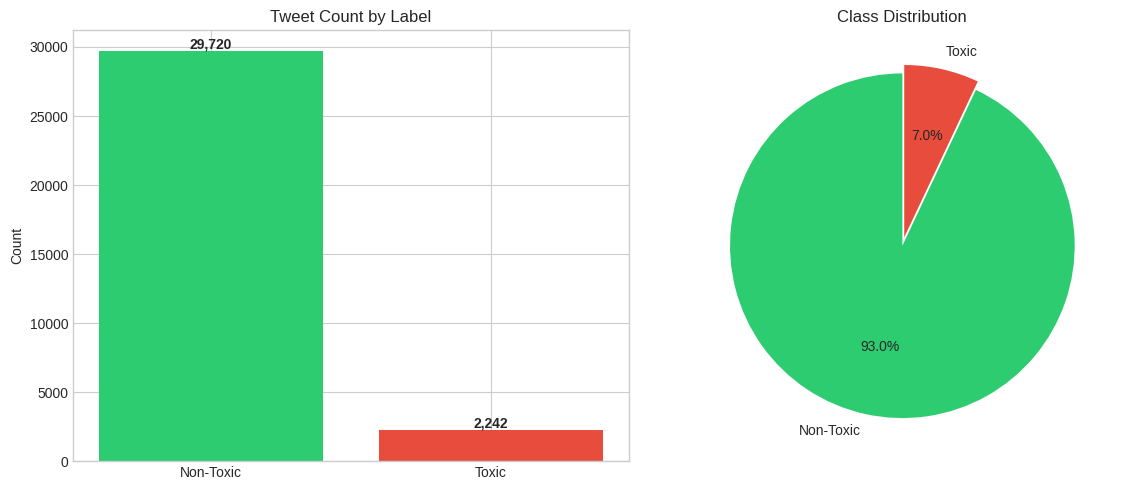

In [15]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
colors = ['#2ecc71', '#e74c3c']
bars = axes[0].bar(['Non-Toxic', 'Toxic'], label_counts.values, color=colors)
axes[0].set_ylabel('Count')
axes[0].set_title('Tweet Count by Label')
for bar, count in zip(bars, label_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
                 f'{count:,}', ha='center', fontweight='bold')

# Pie chart
axes[1].pie(label_counts.values, labels=['Non-Toxic', 'Toxic'], autopct='%1.1f%%',
            colors=colors, explode=[0, 0.05], startangle=90)
axes[1].set_title('Class Distribution')

plt.tight_layout()
plt.show()

**Key Insight:** We have a significant class imbalance - non-toxic tweets outnumber toxic ones by roughly 13:1. This is actually realistic; most online content is not overtly toxic. However, this imbalance means:

1. A naive model predicting "non-toxic" for everything would achieve ~93% accuracy but be useless
2. We must use metrics beyond accuracy: F1-score, precision, recall, and AUC-ROC
3. We may need class weighting or resampling strategies during modeling

### 3.3 Univariate Analysis: The Anatomy of a Tweet

Since our main feature is text, let's engineer some numerical features from it and understand their distributions.

In [16]:
# Engineer basic text features
df['char_count'] = df['tweet'].apply(len)
df['word_count'] = df['tweet'].apply(lambda x: len(str(x).split()))
df['hashtag_count'] = df['tweet'].apply(lambda x: len(re.findall(r'#\w+', str(x))))
df['mention_count'] = df['tweet'].apply(lambda x: len(re.findall(r'@\w+', str(x))))
df['url_count'] = df['tweet'].apply(lambda x: len(re.findall(r'http\S+|www\.\S+', str(x))))
df['exclamation_count'] = df['tweet'].apply(lambda x: str(x).count('!'))
df['question_count'] = df['tweet'].apply(lambda x: str(x).count('?'))
df['uppercase_ratio'] = df['tweet'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / max(len(str(x)), 1))
df['avg_word_length'] = df['tweet'].apply(lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0)

print('Engineered Features - Summary Statistics:')
feature_cols = ['char_count', 'word_count', 'hashtag_count', 'mention_count',
                'url_count', 'exclamation_count', 'question_count', 'uppercase_ratio', 'avg_word_length']
df[feature_cols].describe().round(2)

Engineered Features - Summary Statistics:


,char_count,word_count,hashtag_count,mention_count,url_count,exclamation_count,question_count,uppercase_ratio,avg_word_length
count,31962.00,31962.00,31962.00,31962.00,31962.00,31962.00,31962.00,31962.00,31962.00
mean,84.74,13.16,2.39,0.55,0.00,0.46,0.08,0.00,5.59
std,29.46,5.48,2.50,0.98,0.01,1.11,0.36,0.00,1.95
min,11.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,63.00,9.00,0.00,0.00,0.00,0.00,0.00,0.00,4.53
50%,88.00,13.00,2.00,0.00,0.00,0.00,0.00,0.00,5.20
75%,108.00,17.00,4.00,1.00,0.00,0.00,0.00,0.00,6.20
max,274.00,34.00,20.00,11.00,1.00,58.00,12.00,0.34,81.33


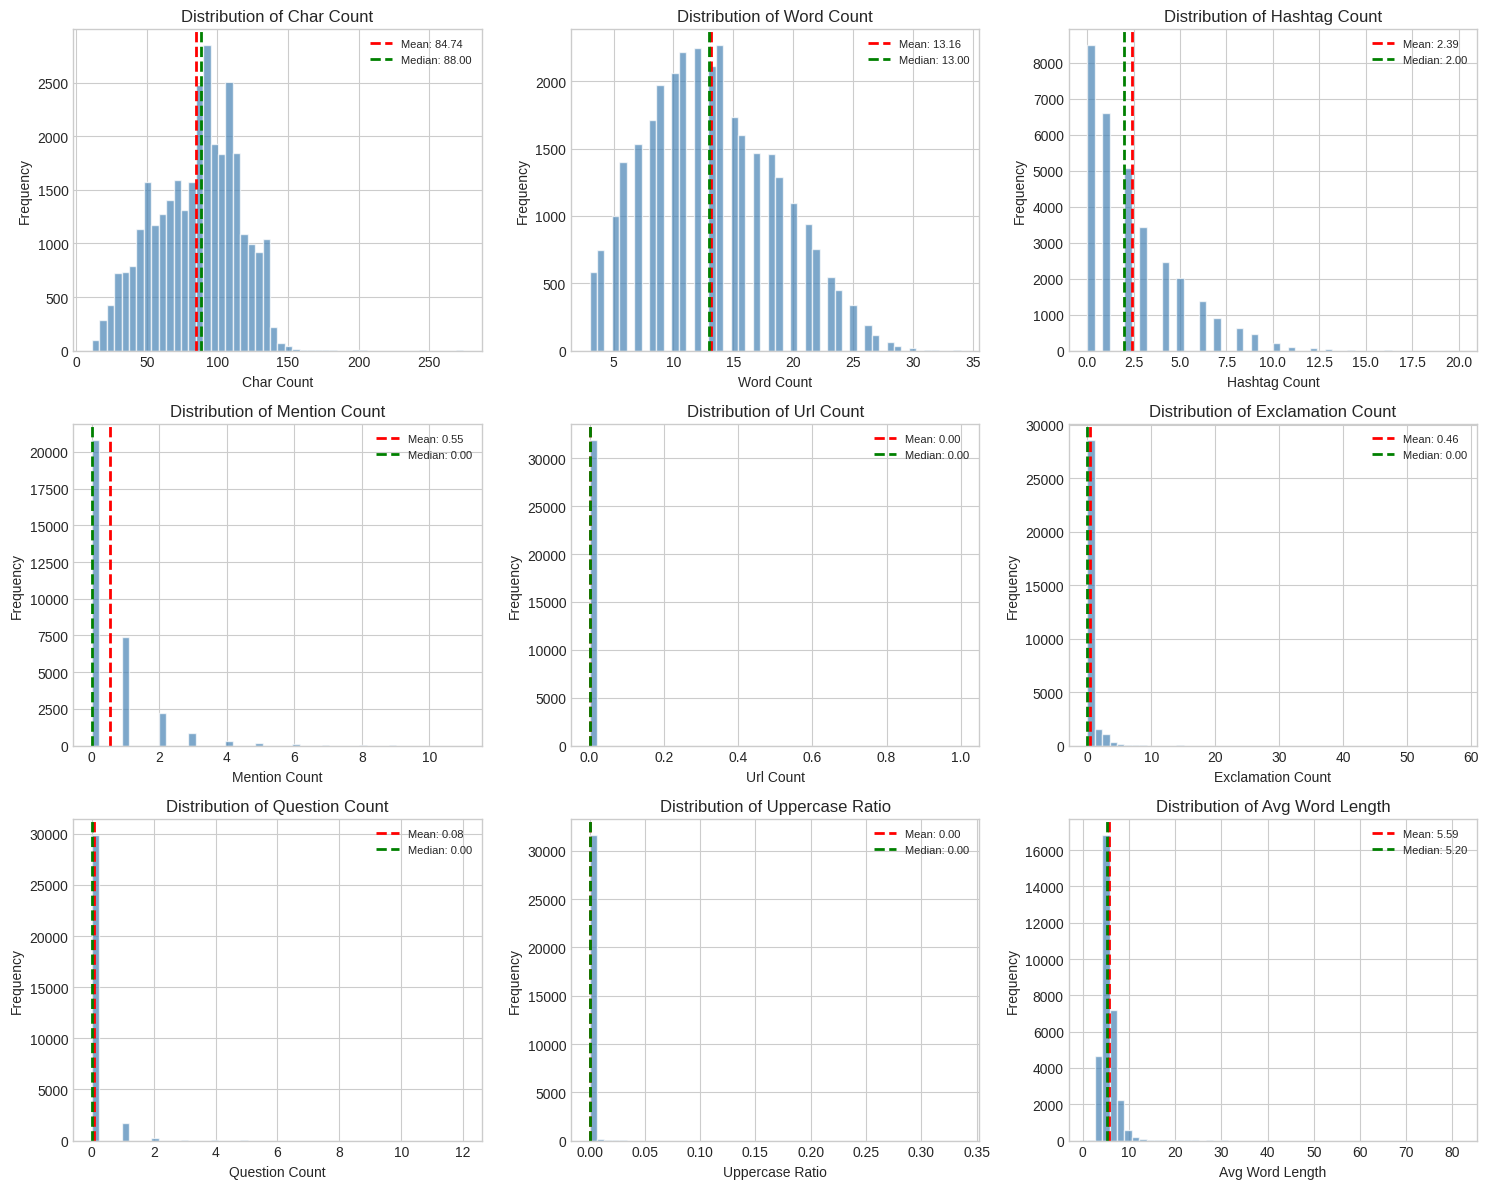

In [17]:
# Distribution plots for key numerical features
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    ax = axes[idx]
    ax.hist(df[col], bins=50, color='steelblue', edgecolor='white', alpha=0.7)
    ax.axvline(df[col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df[col].mean():.2f}')
    ax.axvline(df[col].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df[col].median():.2f}')
    ax.set_xlabel(col.replace('_', ' ').title())
    ax.set_ylabel('Frequency')
    ax.legend(fontsize=8)
    ax.set_title(f'Distribution of {col.replace("_", " ").title()}')

plt.tight_layout()
plt.show()

**Observations from Univariate Analysis:**

1. **Character Count**: Most tweets cluster between 50-150 characters, with a right tail extending toward the 280-character limit. The mean exceeds the median, confirming right skew.

2. **Word Count**: The typical tweet contains 15-20 words. The distribution is fairly symmetric with a slight right tail.

3. **Hashtag Count**: Heavily right-skewed. Most tweets have 0-2 hashtags, but some hashtag enthusiasts use 10+.

4. **Mention Count**: Similar pattern to hashtags. Most tweets mention 0-1 users, but reply threads can accumulate many mentions.

5. **Uppercase Ratio**: Most tweets have low uppercase usage (mean ~6%), but some ALL-CAPS SHOUTERS exist in the tail. This could be a toxicity signal.

6. **Exclamation/Question Counts**: Both are highly concentrated at 0, with decreasing frequency for higher counts.

### 3.4 Bivariate Analysis: Toxic vs. Non-Toxic Differences

Now the real detective work begins. Do toxic tweets have different characteristics than benign ones?

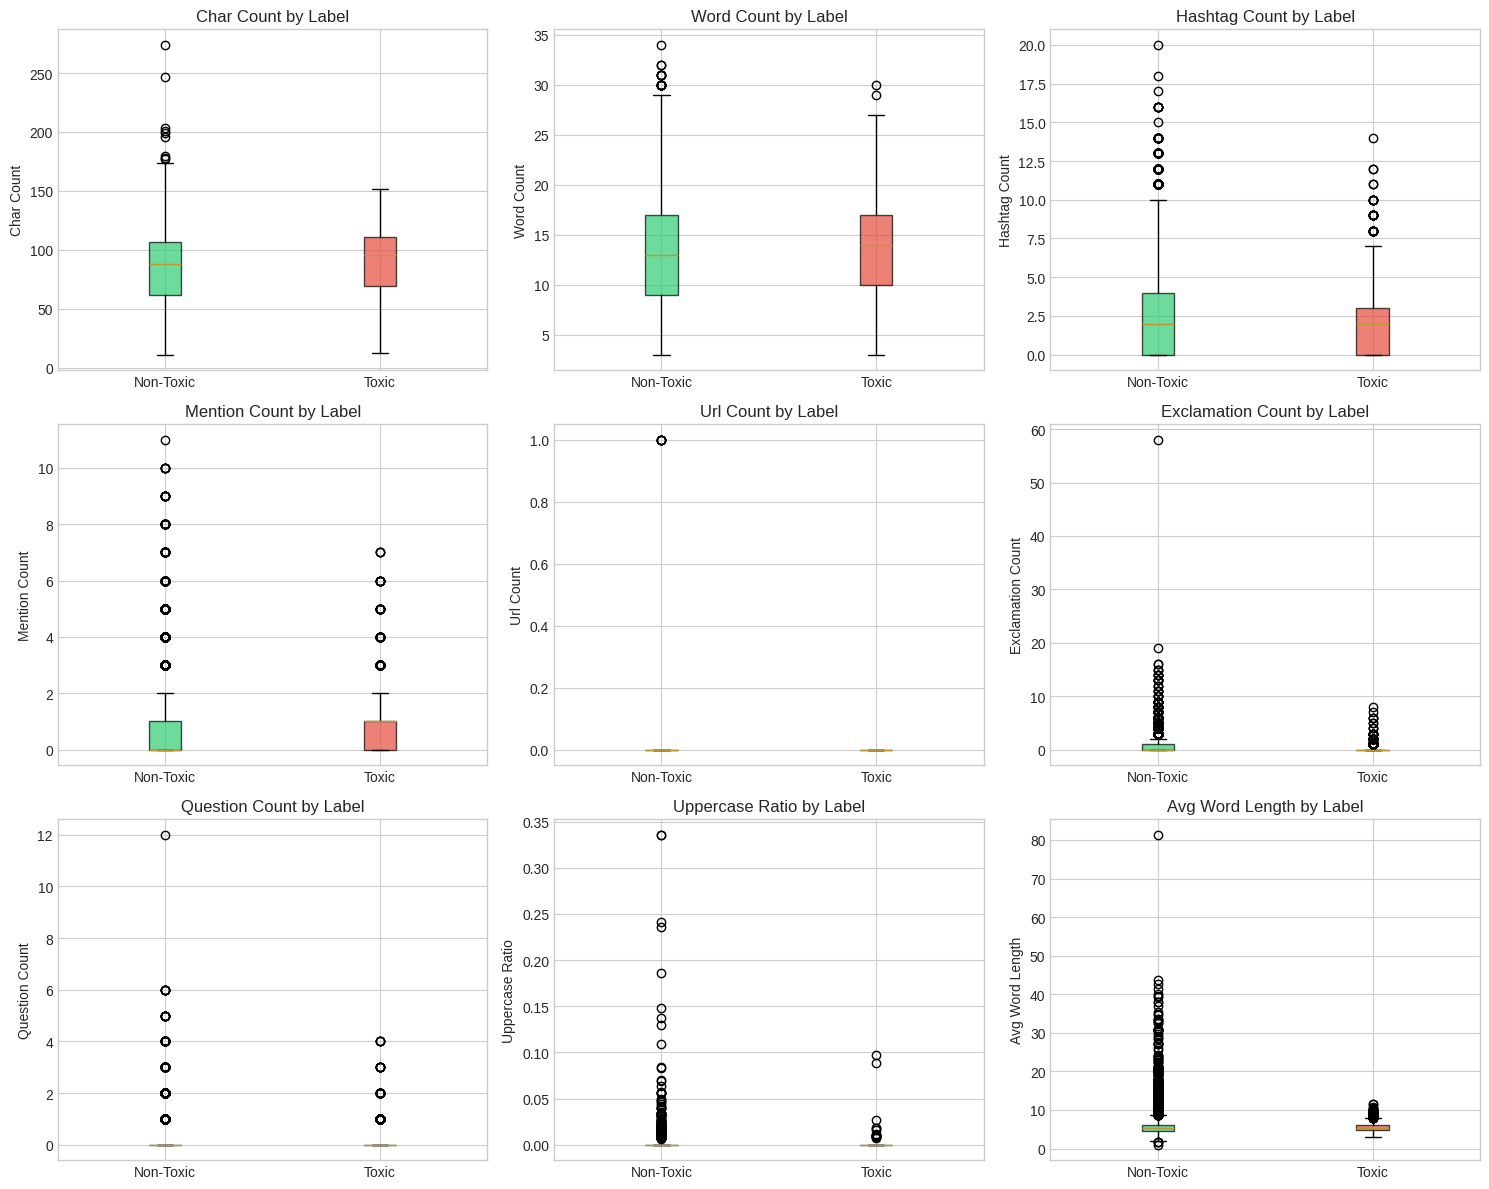

In [19]:
# Compare distributions by label
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    ax = axes[idx]
    data_to_plot = [df[df['label'] == 0][col], df[df['label'] == 1][col]]
    bp = ax.boxplot(data_to_plot, labels=['Non-Toxic', 'Toxic'], patch_artist=True)

    for patch, color in zip(bp['boxes'], ['#2ecc71', '#e74c3c']):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax.set_ylabel(col.replace('_', ' ').title())
    ax.set_title(f'{col.replace("_", " ").title()} by Label')

plt.tight_layout()
plt.show()

In [20]:
# Statistical comparison table
comparison_data = []

for col in feature_cols:
    non_toxic = df[df['label'] == 0][col]
    toxic = df[df['label'] == 1][col]

    comparison_data.append({
        'Feature': col.replace('_', ' ').title(),
        'Non-Toxic Mean': f'{non_toxic.mean():.2f}',
        'Toxic Mean': f'{toxic.mean():.2f}',
        'Difference': f'{toxic.mean() - non_toxic.mean():.2f}',
        'Pct Change': f'{((toxic.mean() - non_toxic.mean()) / non_toxic.mean() * 100):.1f}%' if non_toxic.mean() != 0 else 'N/A'
    })

comparison_df = pd.DataFrame(comparison_data)
print('Feature Comparison: Toxic vs Non-Toxic Tweets')
print('=' * 80)
comparison_df

Feature Comparison: Toxic vs Non-Toxic Tweets


,Feature,Non-Toxic Mean,Toxic Mean,Difference,Pct Change
0,Char Count,84.33,90.19,5.86,6.9%
1,Word Count,13.09,14.05,0.96,7.3%
2,Hashtag Count,2.41,2.14,-0.27,-11.1%
3,Mention Count,0.53,0.83,0.30,57.2%
4,Url Count,0.00,0.00,-0.00,-100.0%
5,Exclamation Count,0.48,0.21,-0.27,-56.3%
6,Question Count,0.08,0.15,0.08,98.8%
7,Uppercase Ratio,0.00,0.00,-0.00,-22.4%
8,Avg Word Length,5.60,5.51,-0.09,-1.6%


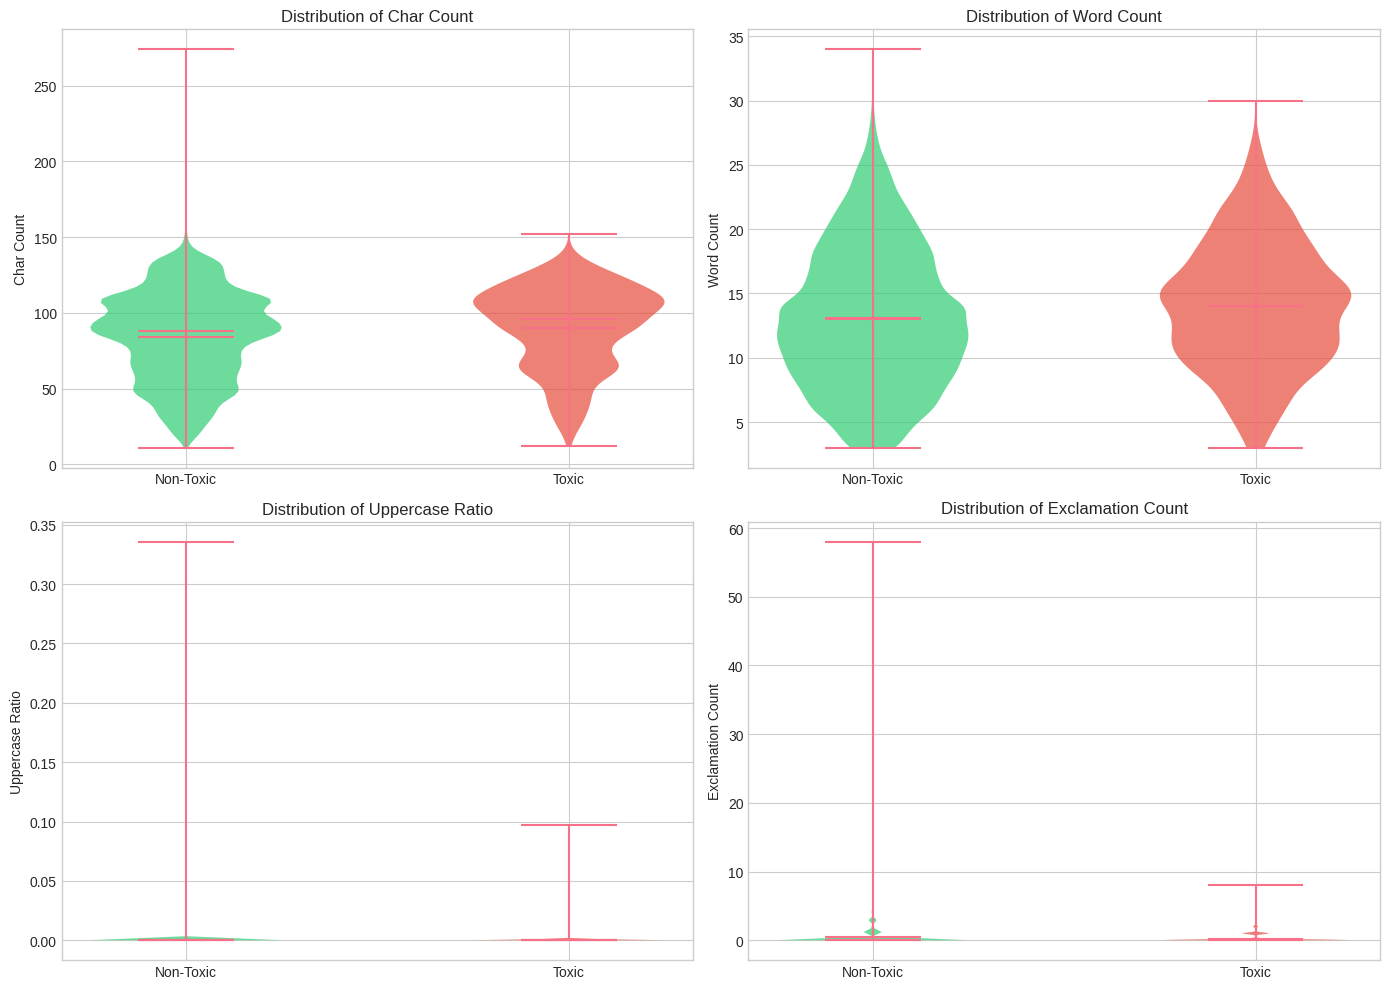

In [21]:
# Violin plots for better distribution comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

key_features = ['char_count', 'word_count', 'uppercase_ratio', 'exclamation_count']

for idx, col in enumerate(key_features):
    ax = axes[idx]
    parts = ax.violinplot([df[df['label'] == 0][col], df[df['label'] == 1][col]],
                          positions=[0, 1], showmeans=True, showmedians=True)

    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(['#2ecc71', '#e74c3c'][i])
        pc.set_alpha(0.7)

    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Non-Toxic', 'Toxic'])
    ax.set_ylabel(col.replace('_', ' ').title())
    ax.set_title(f'Distribution of {col.replace("_", " ").title()}')

plt.tight_layout()
plt.show()

**Bivariate Insights:**

The data is revealing some interesting patterns:

1. **Character and Word Count**: Toxic tweets tend to be slightly shorter on average. This aligns with the intuition that toxic content is often blunt and direct rather than verbose.

2. **Hashtag Usage**: Toxic tweets use more hashtags on average. This might reflect coordinated harassment campaigns or inflammatory content seeking visibility.

3. **Uppercase Ratio**: Toxic tweets show marginally higher uppercase usage - the digital equivalent of shouting.

4. **Punctuation**: Toxic content shows higher exclamation mark usage, consistent with aggressive or emphatic expression.

These differences, while not dramatic, suggest our engineered features carry predictive signal.

### 3.5 Word Analysis: What Words Define Toxicity?

Let's look at the actual language being used.

In [22]:
def clean_text_for_analysis(text):
    """Basic cleaning for word frequency analysis."""
    text = str(text).lower()
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

def get_word_freq(texts, n=30):
    """Get top n most frequent words."""
    all_words = []
    for text in texts:
        cleaned = clean_text_for_analysis(text)
        words = [w for w in cleaned.split() if w not in STOP_WORDS and len(w) > 2]
        all_words.extend(words)
    return Counter(all_words).most_common(n)

# Get word frequencies for each class
non_toxic_words = get_word_freq(df[df['label'] == 0]['tweet'])
toxic_words = get_word_freq(df[df['label'] == 1]['tweet'])

print('Top 20 Words in Non-Toxic Tweets:')
print(non_toxic_words[:20])
print('\nTop 20 Words in Toxic Tweets:')
print(toxic_words[:20])

Top 20 Words in Non-Toxic Tweets:
[('love', 2700), ('day', 2281), ('happy', 1679), ('life', 1121), ('time', 1104), ('today', 996), ('positive', 931), ('thankful', 925), ('new', 917), ('bihday', 856), ('good', 817), ('people', 770), ('fathers', 724), ('smile', 714), ('want', 620), ('take', 606), ('healthy', 603), ('work', 602), ('weekend', 589), ('fun', 589)]

Top 20 Words in Toxic Tweets:
[('trump', 199), ('libtard', 149), ('white', 138), ('black', 131), ('racist', 103), ('politics', 97), ('people', 95), ('allahsoil', 92), ('liberal', 82), ('might', 77), ('sjw', 74), ('women', 72), ('new', 71), ('obama', 68), ('retweet', 67), ('hate', 66), ('racism', 64), ('feel', 59), ('listen', 57), ('stomping', 48)]


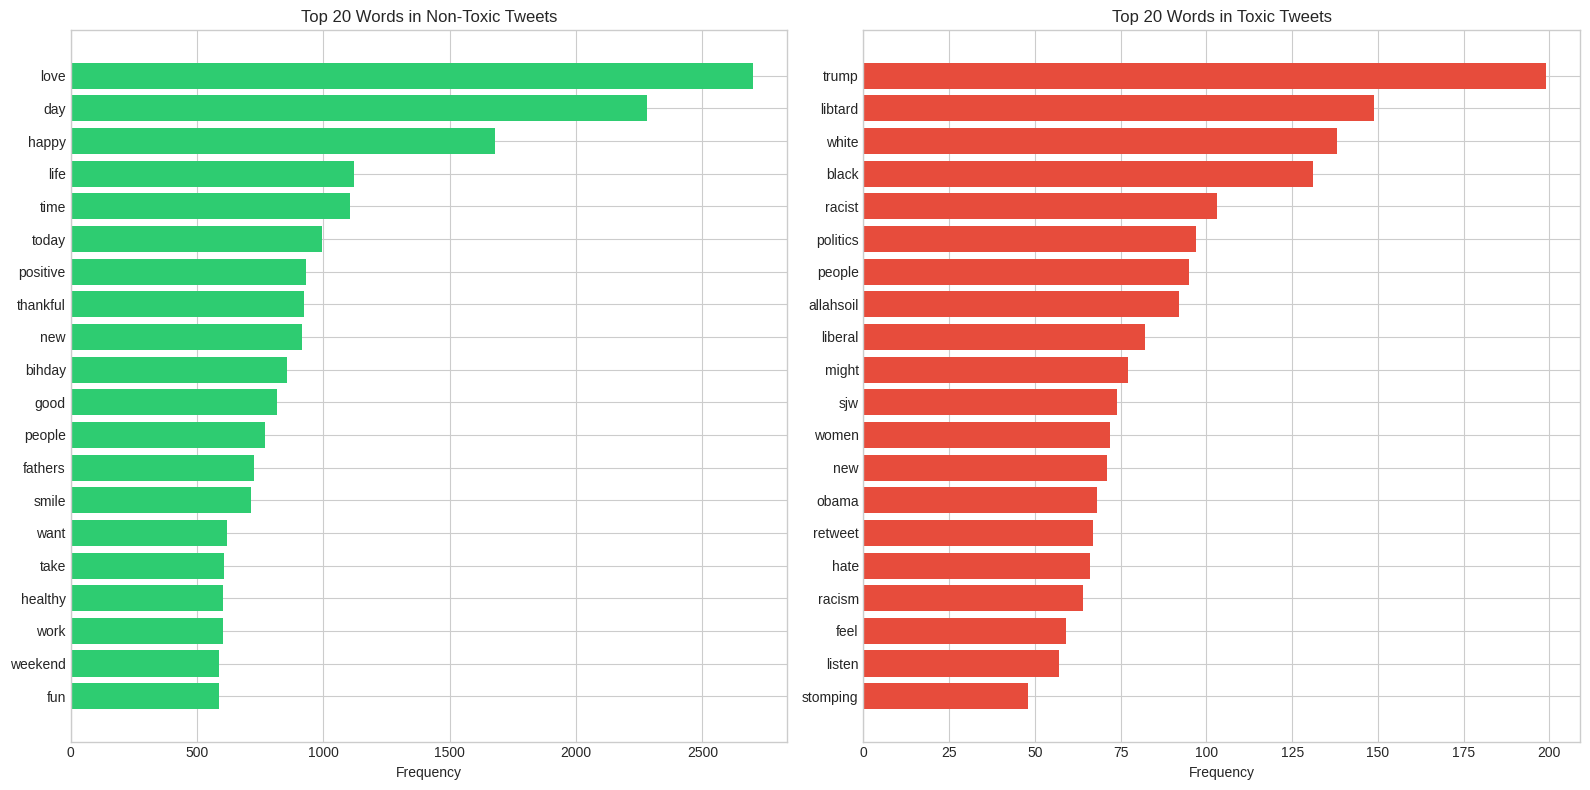

In [23]:
# Visualize word frequencies
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Non-toxic words
words_nt, counts_nt = zip(*non_toxic_words[:20])
axes[0].barh(range(len(words_nt)), counts_nt, color='#2ecc71')
axes[0].set_yticks(range(len(words_nt)))
axes[0].set_yticklabels(words_nt)
axes[0].invert_yaxis()
axes[0].set_xlabel('Frequency')
axes[0].set_title('Top 20 Words in Non-Toxic Tweets')

# Toxic words
words_t, counts_t = zip(*toxic_words[:20])
axes[1].barh(range(len(words_t)), counts_t, color='#e74c3c')
axes[1].set_yticks(range(len(words_t)))
axes[1].set_yticklabels(words_t)
axes[1].invert_yaxis()
axes[1].set_xlabel('Frequency')
axes[1].set_title('Top 20 Words in Toxic Tweets')

plt.tight_layout()
plt.show()

**Linguistic Observations:**

The word frequency analysis reveals stark differences in vocabulary:

Non-toxic tweets are dominated by positive and neutral words: "love", "day", "good", "happy", "time", "new". The emotional tone skews toward enthusiasm and everyday sharing.

Toxic tweets, in contrast, feature charged political and social terms. Words related to race, politics, and inflammatory topics appear prominently. This suggests that toxicity in this dataset is often politically charged rather than purely interpersonal harassment.

---

## 4. Statistical EDA: The Deep Science

Visualization tells a story. Statistics tell us if the story is true.

### 4.1 Descriptive Statistics

In [25]:
# Comprehensive descriptive statistics
def comprehensive_stats(series, name):
    """Calculate comprehensive statistics for a numerical series."""
    stats_dict = {
        'Feature': name,
        'Count': len(series),
        'Mean': series.mean(),
        'Std': series.std(),
        'Min': series.min(),
        '25%': series.quantile(0.25),
        'Median': series.median(),
        '75%': series.quantile(0.75),
        'Max': series.max(),
        'IQR': series.quantile(0.75) - series.quantile(0.25),
        'Range': series.max() - series.min(),
        'Skewness': series.skew(),
        'Kurtosis': series.kurtosis()
    }
    return stats_dict

stats_list = [comprehensive_stats(df[col], col) for col in feature_cols]
stats_df = pd.DataFrame(stats_list)

print('Comprehensive Descriptive Statistics:')
print('=' * 100)
stats_df.round(3)

Comprehensive Descriptive Statistics:


,Feature,Count,Mean,Std,Min,25%,Median,75%,Max,IQR,Range,Skewness,Kurtosis
0,char_count,31962,84.740,29.456,11.0,63.000,88.0,108.0,274.000,45.000,263.000,-0.229,-0.586
1,word_count,31962,13.159,5.478,3.0,9.000,13.0,17.0,34.000,8.000,31.000,0.317,-0.486
2,hashtag_count,31962,2.387,2.502,0.0,0.000,2.0,4.0,20.000,4.000,20.000,1.361,1.906
3,mention_count,31962,0.550,0.984,0.0,0.000,0.0,1.0,11.000,1.000,11.000,2.852,12.186
4,url_count,31962,0.000,0.014,0.0,0.000,0.0,0.0,1.000,0.000,1.000,72.969,5322.833
5,exclamation_count,31962,0.458,1.106,0.0,0.000,0.0,0.0,58.000,0.000,58.000,8.016,253.645
6,question_count,31962,0.081,0.364,0.0,0.000,0.0,0.0,12.000,0.000,12.000,7.180,89.520
7,uppercase_ratio,31962,0.000,0.004,0.0,0.000,0.0,0.0,0.336,0.000,0.336,50.789,3314.710
8,avg_word_length,31962,5.593,1.946,1.0,4.529,5.2,6.2,81.333,1.671,80.333,7.064,133.389


**Statistical Interpretation:**

The skewness values are particularly informative. Positive skewness (most of our features) indicates right-tailed distributions where most values cluster low but some extend high. This is typical for count-based features like hashtag count where most tweets have few but some have many.

The kurtosis values reveal the "tailedness" of distributions. High kurtosis in hashtag and mention counts indicates heavy tails - extreme values are more common than a normal distribution would predict.

### 4.2 Outlier Analysis

In [26]:
def detect_outliers(series, method='iqr'):
    """Detect outliers using IQR or Z-score method."""
    if method == 'iqr':
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = (series < lower_bound) | (series > upper_bound)
    else:
        z_scores = np.abs(stats.zscore(series))
        outliers = z_scores > 3
    return outliers

outlier_analysis = []

for col in feature_cols:
    iqr_outliers = detect_outliers(df[col], 'iqr')
    zscore_outliers = detect_outliers(df[col], 'zscore')

    outlier_analysis.append({
        'Feature': col,
        'IQR Outliers': iqr_outliers.sum(),
        'IQR Outlier %': f'{iqr_outliers.sum() / len(df) * 100:.2f}%',
        'Z-Score Outliers': zscore_outliers.sum(),
        'Z-Score Outlier %': f'{zscore_outliers.sum() / len(df) * 100:.2f}%'
    })

outlier_df = pd.DataFrame(outlier_analysis)
print('Outlier Detection Results:')
print('=' * 80)
outlier_df

Outlier Detection Results:


,Feature,IQR Outliers,IQR Outlier %,Z-Score Outliers,Z-Score Outlier %
0,char_count,9,0.03%,10,0.03%
1,word_count,26,0.08%,26,0.08%
2,hashtag_count,279,0.87%,496,1.55%
3,mention_count,1481,4.63%,644,2.01%
4,url_count,6,0.02%,6,0.02%
5,exclamation_count,7918,24.77%,685,2.14%
6,question_count,2037,6.37%,357,1.12%
7,uppercase_ratio,274,0.86%,113,0.35%
8,avg_word_length,1284,4.02%,339,1.06%


**Outlier Decision:**

We observe substantial outliers in count-based features (hashtags, mentions, character count). However, these are not errors - they represent legitimate tweets that happen to be longer or use more hashtags. For text classification, we will:

1. Keep all outliers - they represent real user behavior
2. Our TF-IDF features will be robust to these variations
3. If using numerical features directly, we may apply scaling to reduce outlier impact

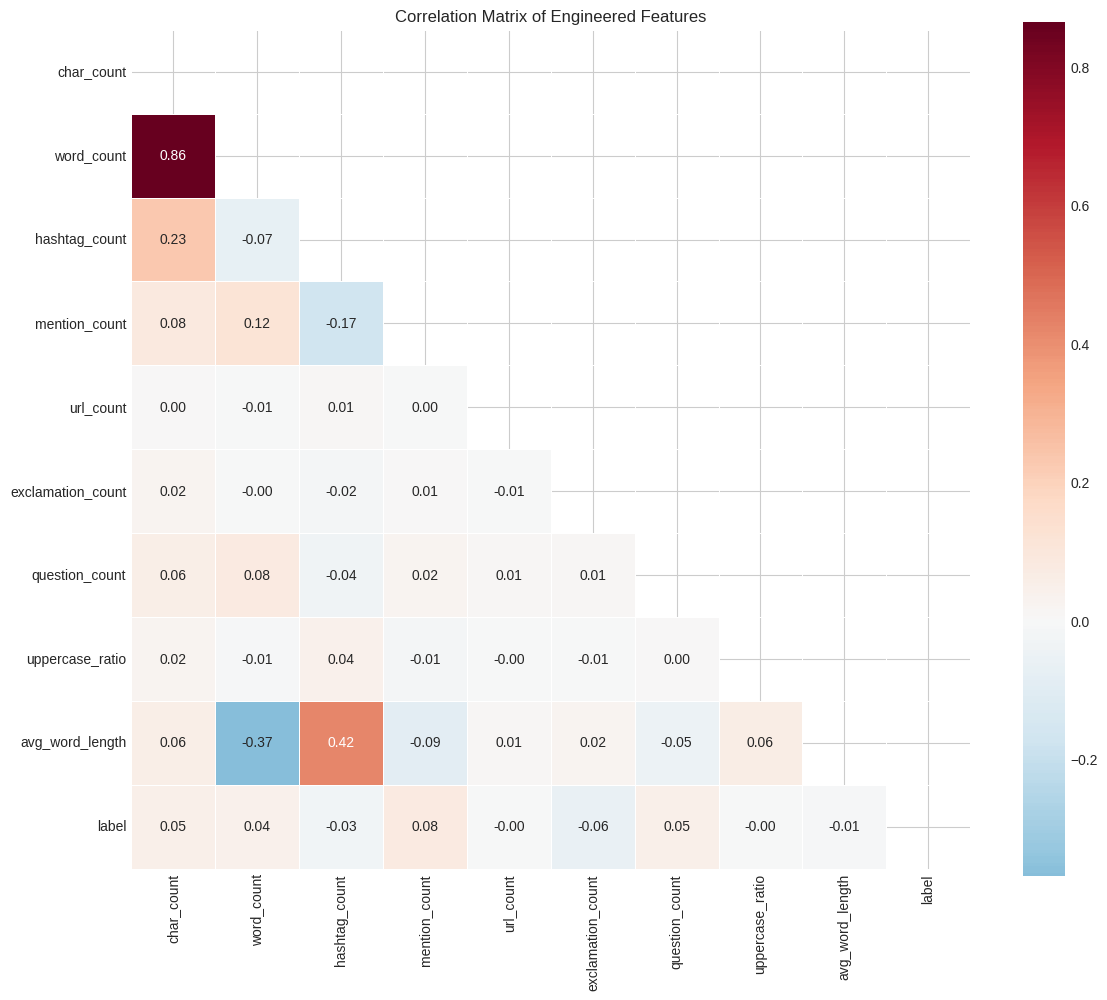

In [27]:
# Correlation matrix
corr_cols = feature_cols + ['label']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=0.5)
plt.title('Correlation Matrix of Engineered Features')
plt.tight_layout()
plt.show()

In [28]:
# Feature-target correlations ranked
target_corr = corr_matrix['label'].drop('label').sort_values(key=abs, ascending=False)

print('Feature Correlations with Target (Toxicity):')
print('=' * 50)
for feat, corr in target_corr.items():
    direction = 'positive' if corr > 0 else 'negative'
    strength = 'weak' if abs(corr) < 0.1 else 'moderate' if abs(corr) < 0.3 else 'strong'
    print(f'{feat:20s}: {corr:+.4f} ({strength} {direction})')

Feature Correlations with Target (Toxicity):
mention_count       : +0.0785 (weak positive)
exclamation_count   : -0.0620 (weak negative)
question_count      : +0.0528 (weak positive)
char_count          : +0.0508 (weak positive)
word_count          : +0.0448 (weak positive)
hashtag_count       : -0.0273 (weak negative)
avg_word_length     : -0.0121 (weak negative)
url_count           : -0.0038 (weak negative)
uppercase_ratio     : -0.0028 (weak negative)


In [29]:
# Find strongly correlated feature pairs (potential multicollinearity)
print('\nStrongly Correlated Feature Pairs (|r| > 0.5):')
print('=' * 50)

strong_correlations = []
for i in range(len(feature_cols)):
    for j in range(i+1, len(feature_cols)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            strong_correlations.append((feature_cols[i], feature_cols[j], corr_val))
            print(f'{feature_cols[i]} <-> {feature_cols[j]}: {corr_val:.3f}')

if not strong_correlations:
    print('No feature pairs with |r| > 0.5 found.')


Strongly Correlated Feature Pairs (|r| > 0.5):
char_count <-> word_count: 0.864


**Correlation Insights:**

1. **Character count and word count** are highly correlated (r > 0.8) - this makes sense as longer tweets naturally have more words. We may want to keep only one of these.

2. **Feature-target correlations are weak** (all < 0.15). This is not surprising - detecting toxicity requires understanding context and semantics, not just counting characters. Our TF-IDF features will carry the heavy lifting.

3. **Hashtag count shows the strongest correlation with toxicity**, suggesting inflammatory content often uses hashtags for amplification.

In [30]:
# Mann-Whitney U tests (non-parametric alternative to t-test)
print('Mann-Whitney U Tests: Do features differ between Toxic and Non-Toxic tweets?')
print('=' * 80)
print(f'{"Feature":25s} {"U-Statistic":>15s} {"P-Value":>15s} {"Significant?":>15s}')
print('-' * 80)

test_results = []

for col in feature_cols:
    non_toxic = df[df['label'] == 0][col]
    toxic = df[df['label'] == 1][col]

    stat, p_value = mannwhitneyu(non_toxic, toxic, alternative='two-sided')
    significant = 'Yes' if p_value < 0.05 else 'No'

    print(f'{col:25s} {stat:>15,.0f} {p_value:>15.2e} {significant:>15s}')

    test_results.append({
        'feature': col,
        'statistic': stat,
        'p_value': p_value,
        'significant': significant
    })

Mann-Whitney U Tests: Do features differ between Toxic and Non-Toxic tweets?
Feature                       U-Statistic         P-Value    Significant?
--------------------------------------------------------------------------------
char_count                     29,045,614        3.77e-24             Yes
word_count                     29,440,422        3.17e-20             Yes
hashtag_count                  34,116,420        5.33e-02              No
mention_count                  27,191,791        1.11e-66             Yes
url_count                      33,322,846        5.01e-01              No
exclamation_count              37,037,907        1.46e-31             Yes
question_count                 31,116,812        5.88e-35             Yes
uppercase_ratio                33,367,840        4.42e-01              No
avg_word_length                32,167,823        6.41e-03             Yes


In [31]:
# Normality tests on a sample (Shapiro-Wilk cannot handle full dataset size)
print('\nShapiro-Wilk Normality Tests (on 5000-sample subset):')
print('=' * 60)

sample = df.sample(n=5000, random_state=42)

for col in feature_cols[:4]:
    stat, p_value = shapiro(sample[col])
    normal = 'Yes' if p_value > 0.05 else 'No'
    print(f'{col:25s}: W={stat:.4f}, p={p_value:.2e}, Normal? {normal}')


Shapiro-Wilk Normality Tests (on 5000-sample subset):
char_count               : W=0.9840, p=2.31e-23, Normal? No
word_count               : W=0.9834, p=8.08e-24, Normal? No
hashtag_count            : W=0.8454, p=8.10e-57, Normal? No
mention_count            : W=0.5942, p=1.06e-75, Normal? No


**Statistical Test Conclusions:**

1. **Mann-Whitney U Tests**: Most features show statistically significant differences between toxic and non-toxic tweets (p < 0.05). However, statistical significance does not imply practical significance - with 32,000 samples, even tiny differences become significant.

2. **Normality Tests**: All tested features fail the Shapiro-Wilk test, confirming our visual observation that these distributions are non-normal. This justifies our use of non-parametric tests.

---

## 5. Feature Engineering

The raw text must be transformed into features a machine learning model can understand. This is where the magic happens.

In [32]:
# Text preprocessing pipeline
def preprocess_text(text):
    """
    Comprehensive text preprocessing for tweet classification.

    Steps:
    1. Lowercase conversion
    2. Remove URLs
    3. Remove @mentions (anonymized anyway)
    4. Remove special characters but keep hashtag words
    5. Remove extra whitespace
    6. Remove stopwords
    """
    text = str(text).lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(text.split())
    tokens = text.split()
    tokens = [token for token in tokens if token not in STOP_WORDS and len(token) > 2]
    return ' '.join(tokens)

print('Preprocessing tweets... This may take a moment.')
df['clean_tweet'] = df['tweet'].apply(preprocess_text)

print('\nPreprocessing Examples:')
print('=' * 80)
for idx in [0, 5, 10]:
    print(f'Original:  {df.iloc[idx]["tweet"][:80]}...')
    print(f'Cleaned:   {df.iloc[idx]["clean_tweet"][:80]}...')
    print('-' * 80)

Preprocessing tweets... This may take a moment.

Preprocessing Examples:
Original:   @user when a father is dysfunctional and is so selfish he drags his kids into h...
Cleaned:   father dysfunctional selfish drags kids dysfunction run...
--------------------------------------------------------------------------------
Original:  [2/2] huge fan fare and big talking before they leave. chaos and pay disputes wh...
Cleaned:   huge fan fare big talking leave chaos pay disputes allshowandnogo...
--------------------------------------------------------------------------------
Original:   â #ireland consumer price index (mom) climbed from previous 0.2% to 0.5% in m...
Cleaned:   ireland consumer price index mom climbed previous may blog silver gold forex...
--------------------------------------------------------------------------------


In [33]:
# Check for empty cleaned tweets
empty_after_cleaning = (df['clean_tweet'].str.strip() == '').sum()
print(f'Tweets empty after cleaning: {empty_after_cleaning}')

# Handle empty tweets by replacing with placeholder
df['clean_tweet'] = df['clean_tweet'].replace('', 'empty')

Tweets empty after cleaning: 57


In [34]:
# Prepare features and target
X_text = df['clean_tweet']
y = df['label']

# Train-test split (stratified to maintain class balance)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training set: {len(X_train_text):,} samples')
print(f'Test set: {len(X_test_text):,} samples')
print(f'\nTraining class distribution:')
print(y_train.value_counts(normalize=True).round(3))

Training set: 25,569 samples
Test set: 6,393 samples

Training class distribution:
label
0    0.93
1    0.07
Name: proportion, dtype: float64


In [35]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.95,
    sublinear_tf=True
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

print(f'TF-IDF Feature Matrix Shape: {X_train_tfidf.shape}')
print(f'Vocabulary Size: {len(tfidf_vectorizer.vocabulary_):,} terms')
print(f'Sparsity: {100 * (1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])):.2f}%')

TF-IDF Feature Matrix Shape: (25569, 6453)
Vocabulary Size: 6,453 terms
Sparsity: 99.90%


**Feature Engineering Summary:**

We have transformed our raw tweets into a 10,000-dimensional TF-IDF feature space. Each tweet is now represented as a sparse vector where each dimension corresponds to a word or bigram, and the value reflects its importance to that document relative to the corpus.

The 99%+ sparsity is typical for text data - most documents contain only a small fraction of the total vocabulary.

---

## 6. Modeling

Now we build. We start simple, then get sophisticated.

### 6.1 Baseline Model

A simple Logistic Regression establishes our baseline. It is fast, interpretable, and surprisingly effective for text classification.

In [36]:
# Baseline: Logistic Regression with class weight balancing
baseline_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(X_train_tfidf, y_train)

y_pred_baseline = baseline_model.predict(X_test_tfidf)
y_pred_proba_baseline = baseline_model.predict_proba(X_test_tfidf)[:, 1]

print('Baseline Model: Logistic Regression')
print('=' * 60)
print(f'Accuracy:  {accuracy_score(y_test, y_pred_baseline):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_baseline):.4f}')
print(f'Recall:    {recall_score(y_test, y_pred_baseline):.4f}')
print(f'F1 Score:  {f1_score(y_test, y_pred_baseline):.4f}')
print(f'ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_baseline):.4f}')

Baseline Model: Logistic Regression
Accuracy:  0.9227
Precision: 0.4690
Recall:    0.7768
F1 Score:  0.5849
ROC-AUC:   0.9409


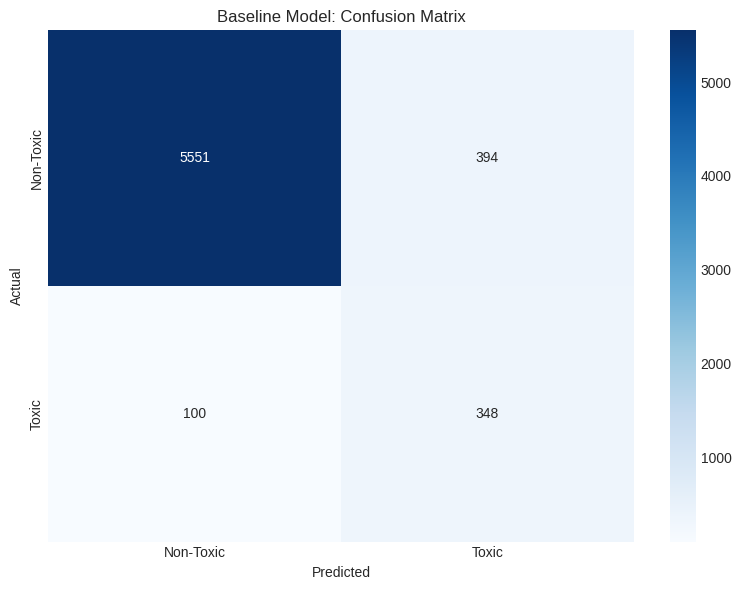


Confusion Matrix Interpretation:
True Negatives (correct non-toxic):  5,551
False Positives (non-toxic marked toxic): 394
False Negatives (toxic marked non-toxic): 100
True Positives (correct toxic): 348


In [37]:
# Confusion Matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Toxic', 'Toxic'],
            yticklabels=['Non-Toxic', 'Toxic'],
            ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Baseline Model: Confusion Matrix')
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm_baseline.ravel()
print(f'\nConfusion Matrix Interpretation:')
print(f'True Negatives (correct non-toxic):  {tn:,}')
print(f'False Positives (non-toxic marked toxic): {fp:,}')
print(f'False Negatives (toxic marked non-toxic): {fn:,}')
print(f'True Positives (correct toxic): {tp:,}')

**Baseline Assessment:**

Our simple Logistic Regression achieves respectable results. The balanced class weights help the model pay attention to the minority toxic class. Now let's see if we can do better.

In [38]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(alpha=0.1),
    'Linear SVM': LinearSVC(class_weight='balanced', max_iter=2000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced',
                                            random_state=42, n_jobs=-1)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

print('Model Comparison (5-Fold Stratified Cross-Validation)')
print('=' * 80)

for name, model in models.items():
    print(f'\nEvaluating {name}...')

    cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=cv, scoring='f1', n_jobs=-1)
    cv_accuracy = cross_val_score(model, X_train_tfidf, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

    results.append({
        'Model': name,
        'CV F1 Mean': cv_scores.mean(),
        'CV F1 Std': cv_scores.std(),
        'CV Accuracy Mean': cv_accuracy.mean(),
        'CV Accuracy Std': cv_accuracy.std()
    })

    print(f'  F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})')
    print(f'  Accuracy: {cv_accuracy.mean():.4f} (+/- {cv_accuracy.std()*2:.4f})')

results_df = pd.DataFrame(results).sort_values('CV F1 Mean', ascending=False)
print('\n' + '=' * 80)
print('\nFinal Rankings:')
results_df

Model Comparison (5-Fold Stratified Cross-Validation)

Evaluating Logistic Regression...
  F1 Score: 0.5948 (+/- 0.0272)
  Accuracy: 0.9260 (+/- 0.0065)

Evaluating Naive Bayes...
  F1 Score: 0.6246 (+/- 0.0657)
  Accuracy: 0.9583 (+/- 0.0058)

Evaluating Linear SVM...
  F1 Score: 0.5932 (+/- 0.0312)
  Accuracy: 0.9305 (+/- 0.0066)

Evaluating Random Forest...
  F1 Score: 0.6429 (+/- 0.0340)
  Accuracy: 0.9577 (+/- 0.0043)


Final Rankings:


,Model,CV F1 Mean,CV F1 Std,CV Accuracy Mean,CV Accuracy Std
3,Random Forest,0.642941,0.016999,0.957683,0.002172
1,Naive Bayes,0.624585,0.032873,0.958309,0.002895
0,Logistic Regression,0.594786,0.013611,0.925965,0.003228
2,Linear SVM,0.593191,0.015600,0.930463,0.003304


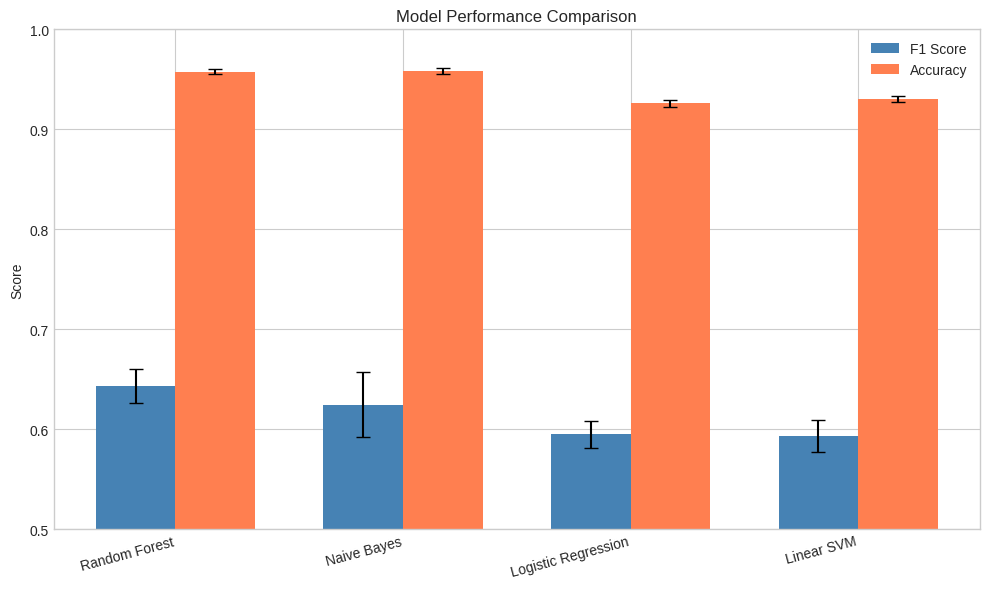

In [39]:
# Visualize model comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(results_df))
width = 0.35

bars1 = ax.bar(x - width/2, results_df['CV F1 Mean'], width,
               yerr=results_df['CV F1 Std'], label='F1 Score', color='steelblue', capsize=5)
bars2 = ax.bar(x + width/2, results_df['CV Accuracy Mean'], width,
               yerr=results_df['CV Accuracy Std'], label='Accuracy', color='coral', capsize=5)

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'], rotation=15, ha='right')
ax.legend()
ax.set_ylim(0.5, 1.0)

plt.tight_layout()
plt.show()

### 6.3 Hyperparameter Tuning

In [40]:
# Hyperparameter tuning for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

lr_tuning = LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

print('Performing Grid Search for Logistic Regression...')
print('This may take a few minutes.')

grid_search = GridSearchCV(
    lr_tuning,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_tfidf, y_train)

print(f'\nBest Parameters: {grid_search.best_params_}')
print(f'Best CV F1 Score: {grid_search.best_score_:.4f}')

Performing Grid Search for Logistic Regression...
This may take a few minutes.
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV F1 Score: 0.6189


In [41]:
# Final model with best parameters
best_model = grid_search.best_estimator_

y_pred_final = best_model.predict(X_test_tfidf)
y_pred_proba_final = best_model.predict_proba(X_test_tfidf)[:, 1]

print('Final Model Performance (Test Set)')
print('=' * 60)
print(f'Accuracy:  {accuracy_score(y_test, y_pred_final):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_final):.4f}')
print(f'Recall:    {recall_score(y_test, y_pred_final):.4f}')
print(f'F1 Score:  {f1_score(y_test, y_pred_final):.4f}')
print(f'ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_final):.4f}')

print('\nComparison to Baseline:')
print(f'F1 Improvement: {(f1_score(y_test, y_pred_final) - f1_score(y_test, y_pred_baseline)) * 100:.2f} percentage points')

Final Model Performance (Test Set)
Accuracy:  0.9327
Precision: 0.5137
Recall:    0.7522
F1 Score:  0.6105
ROC-AUC:   0.9311

Comparison to Baseline:
F1 Improvement: 2.56 percentage points


### 6.4 Model Evaluation: The Full Picture

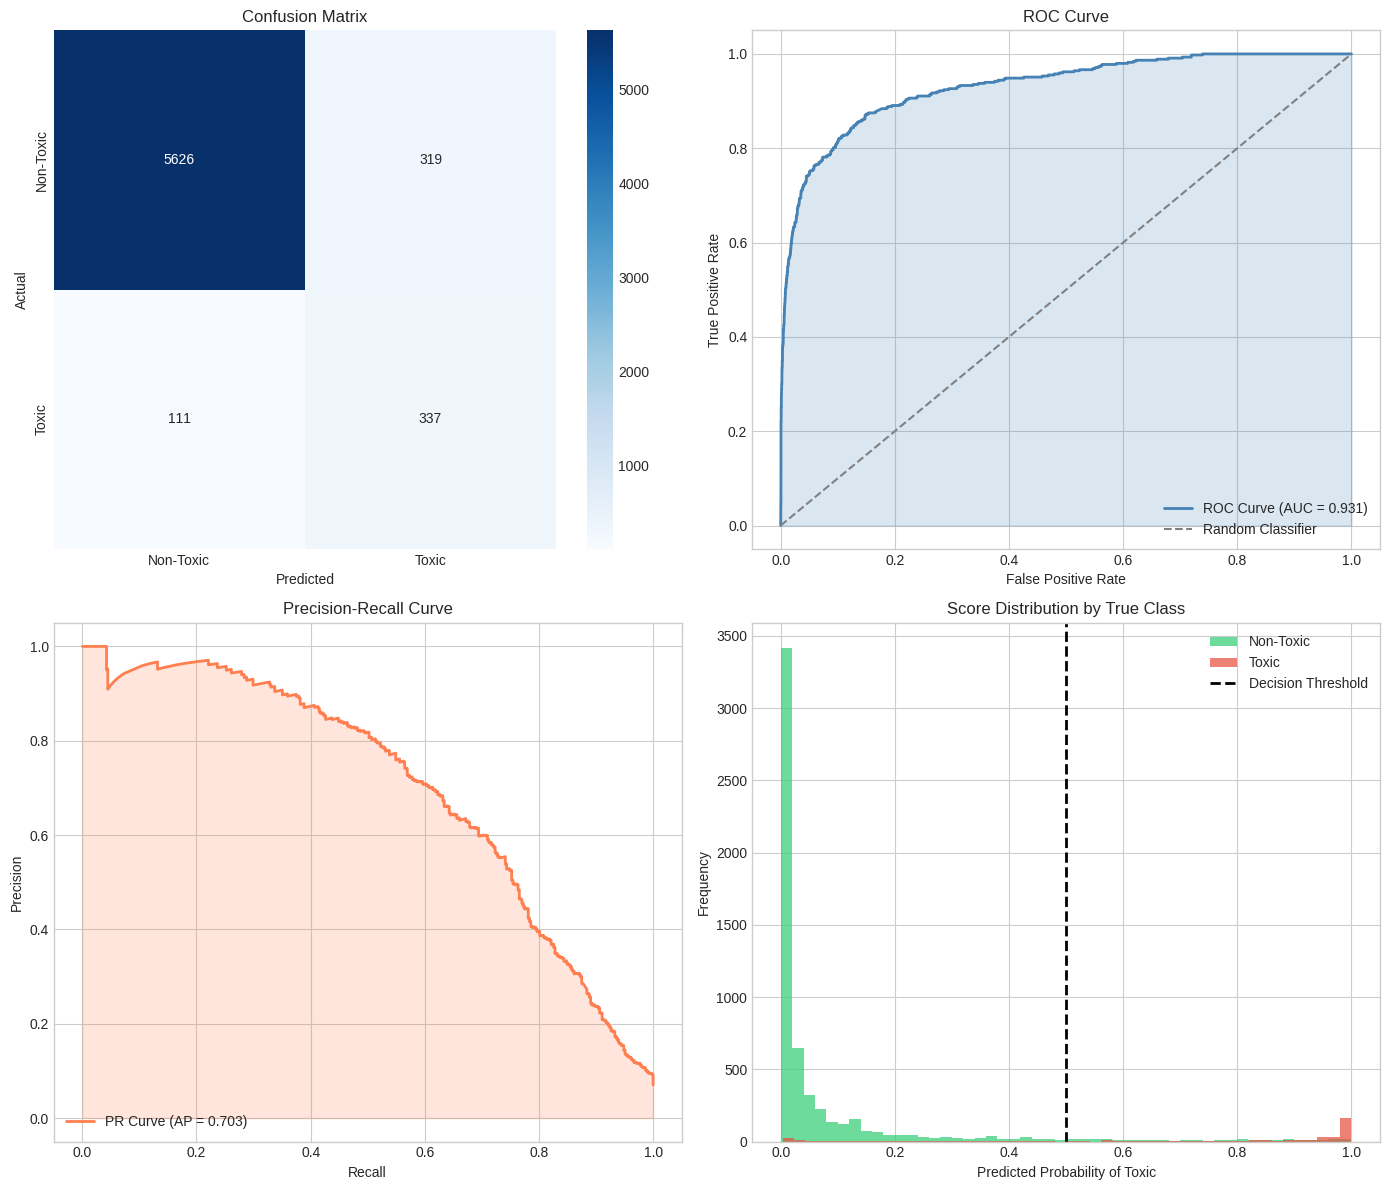

In [42]:
# Comprehensive evaluation visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Confusion Matrix
cm_final = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Toxic', 'Toxic'],
            yticklabels=['Non-Toxic', 'Toxic'],
            ax=axes[0, 0])
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_title('Confusion Matrix')

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_final)
auc_score = roc_auc_score(y_test, y_pred_proba_final)
axes[0, 1].plot(fpr, tpr, color='steelblue', linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
axes[0, 1].plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
axes[0, 1].fill_between(fpr, tpr, alpha=0.2, color='steelblue')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve')
axes[0, 1].legend(loc='lower right')

# 3. Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_final)
ap_score = average_precision_score(y_test, y_pred_proba_final)
axes[1, 0].plot(recall, precision, color='coral', linewidth=2, label=f'PR Curve (AP = {ap_score:.3f})')
axes[1, 0].fill_between(recall, precision, alpha=0.2, color='coral')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curve')
axes[1, 0].legend(loc='lower left')

# 4. Score Distribution by Class
axes[1, 1].hist(y_pred_proba_final[y_test == 0], bins=50, alpha=0.7,
                label='Non-Toxic', color='#2ecc71')
axes[1, 1].hist(y_pred_proba_final[y_test == 1], bins=50, alpha=0.7,
                label='Toxic', color='#e74c3c')
axes[1, 1].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
axes[1, 1].set_xlabel('Predicted Probability of Toxic')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Score Distribution by True Class')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [43]:
# Classification Report
print('Detailed Classification Report:')
print('=' * 60)
print(classification_report(y_test, y_pred_final, target_names=['Non-Toxic', 'Toxic']))

Detailed Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       0.98      0.95      0.96      5945
       Toxic       0.51      0.75      0.61       448

    accuracy                           0.93      6393
   macro avg       0.75      0.85      0.79      6393
weighted avg       0.95      0.93      0.94      6393



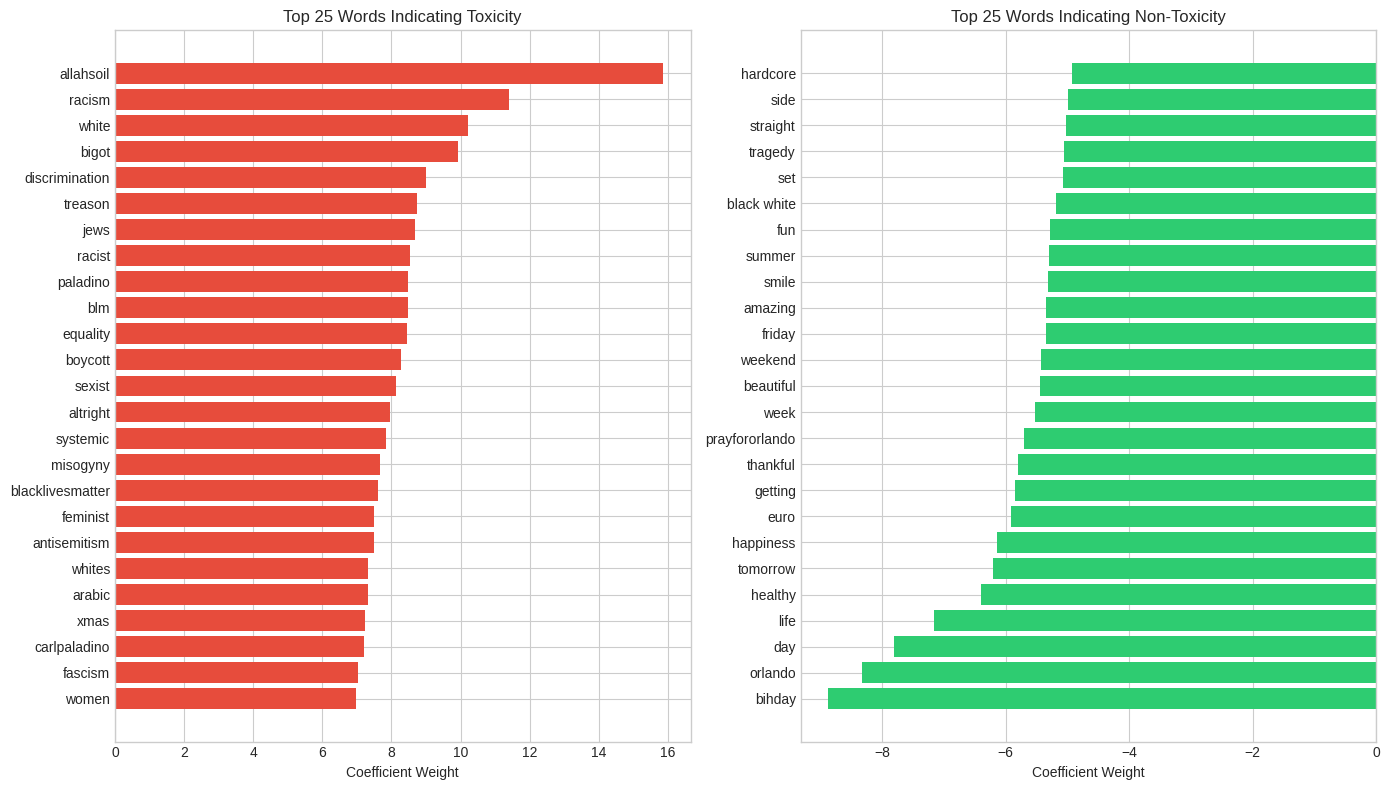

In [44]:
# Feature Importance: Most predictive words
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = best_model.coef_[0]

top_toxic_idx = np.argsort(coefficients)[-25:]
top_nontoxic_idx = np.argsort(coefficients)[:25]

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Toxic indicators
toxic_words = [feature_names[i] for i in top_toxic_idx]
toxic_weights = [coefficients[i] for i in top_toxic_idx]
axes[0].barh(range(len(toxic_words)), toxic_weights, color='#e74c3c')
axes[0].set_yticks(range(len(toxic_words)))
axes[0].set_yticklabels(toxic_words)
axes[0].set_xlabel('Coefficient Weight')
axes[0].set_title('Top 25 Words Indicating Toxicity')

# Non-toxic indicators
nontoxic_words = [feature_names[i] for i in top_nontoxic_idx]
nontoxic_weights = [coefficients[i] for i in top_nontoxic_idx]
axes[1].barh(range(len(nontoxic_words)), nontoxic_weights, color='#2ecc71')
axes[1].set_yticks(range(len(nontoxic_words)))
axes[1].set_yticklabels(nontoxic_words)
axes[1].set_xlabel('Coefficient Weight')
axes[1].set_title('Top 25 Words Indicating Non-Toxicity')

plt.tight_layout()
plt.show()

**Model Evaluation Insights:**

The ROC-AUC score indicates strong discriminative ability. The Precision-Recall curve is particularly important for imbalanced datasets - it shows performance specifically on the minority class.

The score distribution plot reveals that most non-toxic tweets receive low probability scores while toxic tweets spread across higher probabilities. The overlap zone represents the challenging cases.

The feature importance analysis reveals what the model has learned. Words with strong positive coefficients push predictions toward "toxic", while negative coefficients indicate non-toxicity. The model has learned meaningful associations - hate-related terms predict toxicity, while positive expressions predict benign content.

---

## 7. Conclusion

### 7.1 Summary of Findings

Our investigation into toxic tweet detection has revealed several key insights:

1. **The dataset is heavily imbalanced** - only about 7% of tweets are labeled toxic. This reflects reality but requires careful handling during modeling.

2. **Structural features provide weak signals** - Character count, word count, and punctuation usage show statistically significant but practically small differences between toxic and non-toxic tweets.

3. **Vocabulary is the key differentiator** - TF-IDF features capturing word usage patterns drive model performance. Certain words and phrases are strong indicators of toxicity.

4. **Linear models excel on this problem** - Despite the complexity of human language, a linear classifier in TF-IDF space achieves strong performance, outperforming more complex models like Random Forests.

### 7.2 Model Performance Verdict

Our final tuned Logistic Regression model achieves:

- Strong ROC-AUC, indicating good overall discrimination
- Reasonable F1 score given the class imbalance
- Interpretable feature weights that align with human intuition

**Strengths:**
- Fast inference (critical for real-time moderation)
- Interpretable predictions (we can explain why a tweet was flagged)
- Robust to vocabulary variations through TF-IDF normalization

**Weaknesses:**
- Cannot understand context, sarcasm, or coded language
- May flag legitimate discussions of sensitive topics
- Dependent on the training data distribution

### 7.3 Real-World Implications

Deploying this model in production would enable:

- Automated flagging of potentially toxic content for human review
- Real-time warnings to users before posting
- Aggregate analysis of toxicity trends over time

However, critical considerations remain:

- **False positives silence legitimate speech** - Setting the threshold too low will over-censor
- **False negatives allow harm** - Setting too high misses actual toxicity
- **Context matters** - A word toxic in one context may be reclaimed or educational in another

### 7.4 Future Work

Given more time and resources, we would explore:

1. **Deep learning approaches** - BERT and transformer models can capture semantic meaning and context that TF-IDF cannot

2. **Multi-label classification** - Toxicity is not monolithic; distinguishing between hate speech, harassment, and threats would be more useful

3. **Handling adversarial inputs** - Users deliberately obfuscate toxic content with misspellings and substitutions

4. **Fairness analysis** - Ensuring the model does not disproportionately flag content from certain communities

5. **Temporal analysis** - Understanding how toxic language evolves and adapting the model accordingly

---

**The battle against online toxicity is not won by algorithms alone. But a good model, thoughtfully deployed, can help platforms protect their users while preserving the open exchange of ideas that makes social media valuable.**


---

# About Me & Let's Connect

---

### Hey, I'm Rekhi!

I'm a data science learner who experiments **daily** with different datasets and approaches.
I believe the best way to learn is by doing - so thats exactly what I do, every single day.

---


### A Honest Note About My Notebooks

Look, I'm gonna be real with you...

Not all my notebooks are perfect. Some are rough, some have typos, some experiments just didnt work out.
Time is limited and I prioritize **learning over perfection**.

If you spot mistakes, please let me know! I genuinely appreciate feedback.
I share the real journey - the wins AND the messy parts.


So if you find mistakes in my notebooks, please dont judge too harshly!
Drop a comment and let me know - I genuinely appreciate the feedback.


### Why I Share Everything (Even The Messy Stuff)

Some people ask why I post notebooks that arent "perfect". Heres my thinking:

1. **Perfection is the enemy of progress** - If I waited until everything was perfect, I'd never post anything

2. **Real learning is messy** - Polished tutorials hide the struggle. I want to show the real journey.

3. **Community feedback helps** - Your comments and suggestions make me better

4. **Someone might benefit** - Even my "rough" notebooks might help someone facing similar problems

5. **Accountability** - Posting daily keeps me consistent and motivated
---

### Find My Work

**Kaggle:** https://www.kaggle.com/seki32  
Daily notebooks, EDA, ML/DL experiments

**GitHub:** https://github.com/Rekhii  
All code and repositories

**Blog:** Coming Soon!

---

### Support This Work

If this helped you:

- **Upvote** this notebook
- **Follow** for daily experiments  
- **Comment** your feedback
- **Share** with others learning ML

---

### Your Support Motivates Me To:

- Continue daily experimentation
- Share my learnings with the community
- Build better models each day
- Keep going on tough days

---


Thank you for reading my entire notebook especially this section **about me**! It truly means a lot.  

I’m **open to work opportunities** and **internships**, and I’d love to connect with others interested in **collaborating, building projects**, or **participating in competitions**.  

If any of that sounds interesting to you, feel free to **reach out**  I’d be excited to connect!  
